# 코딩 준비

참조 document : https://web.mit.edu/music21/doc/index.html
참조 예제 : https://bit.ly/2HQ9Q4J
참조 데이터 : https://tykimos.github.io/2017/04/09/RNN_Layer_Talk/
악보 처리용 프로그램 추가 :https://musescore.org (MuseScore3인스톨)
악보를 보기 위한 setting :
us=music21.environment.UserSettings()
us["musescoreDirectPNGPath"]="C:/Program Files/MuseScore 3/bin/MuseScore3.exe"

In [4]:
import music21
import tensorflow as tf
import tensorflow.keras.utils as utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os

# 데이터 준비하기
## 시퀀스 정의

In [5]:
seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

print("length of seq: {0}".format(len(seq)))

length of seq: 54


In [6]:
note_seq=" ".join(seq)
note_seq
m = music21.converter.parse("2/4"+note_seq, format="tinyNotation")

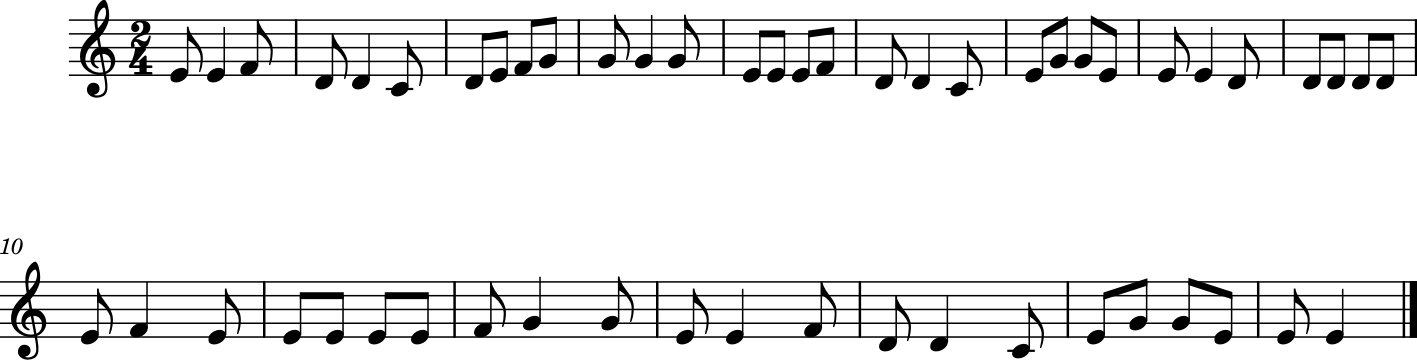

In [9]:
us=music21.environment.UserSettings()
us["musescoreDirectPNGPath"]="C:/Program Files/MuseScore 3/bin/MuseScore3.exe"
m.show()

In [11]:
m.show('midi')

In [13]:
from keras_preprocessing.text import Tokenizer
t=Tokenizer()
t.fit_on_texts([seq])
encoded=t.texts_to_sequences([seq])[0]
print(encoded)
print(t.word_index)

[2, 1, 5, 4, 3, 6, 7, 3, 1, 4, 2, 2, 8, 2, 1, 1, 1, 4, 3, 6, 7, 1, 2, 2, 1, 1, 5, 3, 3, 3, 3, 3, 1, 9, 1, 1, 1, 1, 1, 4, 8, 2, 1, 5, 4, 3, 6, 7, 1, 2, 2, 1, 1, 5]
{'e8': 1, 'g8': 2, 'd8': 3, 'f8': 4, 'e4': 5, 'd4': 6, 'c8': 7, 'g4': 8, 'f4': 9}


In [14]:
code2idx = {'c4': 0, 'd4': 1, 'e4': 2, 'f4': 3, 'g4': 4, 'a4': 5, 'b4': 6,
            'c8': 7, 'd8': 8, 'e8': 9, 'f8': 10, 'g8': 11, 'a8': 12, 'b8': 13}

idx2code = {0: 'c4', 1: 'd4', 2: 'e4', 3: 'f4', 4: 'g4', 5: 'a4', 6: 'b4',
            7: 'c8', 8: 'd8', 9: 'e8', 10: 'f8', 11: 'g8', 12: 'a8', 13: 'b8'}

# 데이터 셋 생성하기

In [64]:
code2idx['g8']

11

In [65]:
print([code2idx[item] for item in seq])

[11, 9, 2, 10, 8, 1, 7, 8, 9, 10, 11, 11, 4, 11, 9, 9, 9, 10, 8, 1, 7, 9, 11, 11, 9, 9, 2, 8, 8, 8, 8, 8, 9, 3, 9, 9, 9, 9, 9, 10, 4, 11, 9, 2, 10, 8, 1, 7, 9, 11, 11, 9, 9, 2]


In [68]:
#seq를 학습시킬 데이터 셋으로 반환하는 함수
# seq = 음계가 담긴 list, window_size:독립변수의 갯수
def seq2dataset(seq, window_size):
    dataset = []
    
    for i in range(len(seq) - window_size):
        subset = seq[i: (i + window_size + 1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)

In [69]:
print(dataset)

None


In [36]:
print(seq[0:10])
print(seq2dataset(seq[0:10],4))

['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8']
[11, 9, 2, 10, 8]
[9, 2, 10, 8, 1]
[2, 10, 8, 1, 7]
[10, 8, 1, 7, 8]
[8, 1, 7, 8, 9]
[1, 7, 8, 9, 10]
None


## 생성

In [52]:
n_steps= 4 #4개씩 학습(독립변수 갯수)
n_inputs=1
dataset= seq2dataset(seq, window_size=n_steps)
print(dataset[:2])
print(dataset.shape)

[11, 9, 2, 10, 8]
[9, 2, 10, 8, 1]
[2, 10, 8, 1, 7]
[10, 8, 1, 7, 8]
[8, 1, 7, 8, 9]
[1, 7, 8, 9, 10]
[7, 8, 9, 10, 11]
[8, 9, 10, 11, 11]
[9, 10, 11, 11, 4]
[10, 11, 11, 4, 11]
[11, 11, 4, 11, 9]
[11, 4, 11, 9, 9]
[4, 11, 9, 9, 9]
[11, 9, 9, 9, 10]
[9, 9, 9, 10, 8]
[9, 9, 10, 8, 1]
[9, 10, 8, 1, 7]
[10, 8, 1, 7, 9]
[8, 1, 7, 9, 11]
[1, 7, 9, 11, 11]
[7, 9, 11, 11, 9]
[9, 11, 11, 9, 9]
[11, 11, 9, 9, 2]
[11, 9, 9, 2, 8]
[9, 9, 2, 8, 8]
[9, 2, 8, 8, 8]
[2, 8, 8, 8, 8]
[8, 8, 8, 8, 8]
[8, 8, 8, 8, 9]
[8, 8, 8, 9, 3]
[8, 8, 9, 3, 9]
[8, 9, 3, 9, 9]
[9, 3, 9, 9, 9]
[3, 9, 9, 9, 9]
[9, 9, 9, 9, 9]
[9, 9, 9, 9, 10]
[9, 9, 9, 10, 4]
[9, 9, 10, 4, 11]
[9, 10, 4, 11, 9]
[10, 4, 11, 9, 2]
[4, 11, 9, 2, 10]
[11, 9, 2, 10, 8]
[9, 2, 10, 8, 1]
[2, 10, 8, 1, 7]
[10, 8, 1, 7, 9]
[8, 1, 7, 9, 11]
[1, 7, 9, 11, 11]
[7, 9, 11, 11, 9]
[9, 11, 11, 9, 9]
[11, 11, 9, 9, 2]


TypeError: 'NoneType' object is not subscriptable

독립변수(X), 종속변수(Y)로 분리

In [42]:
x_train=dataset[:,:-1]
y_train=dataset[:,-1]
print(dataset[0])
print(x_train[0], y_train[0])
print(x_train.shape,y_train.shape)

TypeError: 'NoneType' object is not subscriptable

In [44]:
# 정규화 시킬 때 나눌 값 : code2idx의 제일 큰 values값
max_idx_value=max(code2idx.values())
max_idx_value

13

## 독립변수 정규화

In [45]:
print('정규화 전 x_train[:2]',x_train[:2],sep="\n")

NameError: name 'x_train' is not defined

NameError: name 'x_train' is not defined